# Selection, transformation, pre-processing and visualization of data loaded from CSV file

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom
import seaborn as sns
import numpy as np
%matplotlib inline

## Let's get to know the data set we are working with

In [2]:
# Set the seed for reproducible results
np.random.seed(123)

# Set plot style
sns.set_style("darkgrid")

# Load the data and get a sample of it
df = pd.read_csv("loans.csv")
df.sample(10)

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
234,272,272,PAIDOFF,1000,30,9/14/2016,11/12/2016,28,college,male
42,51,51,PAIDOFF,1000,30,9/11/2016,10/10/2016,35,Bechalor,female
303,354,354,COLLECTION,1000,30,9/11/2016,10/10/2016,37,High School or Below,male
155,183,183,PAIDOFF,800,15,9/12/2016,9/26/2016,30,High School or Below,male
342,395,395,COLLECTION,1000,30,9/11/2016,10/10/2016,25,High School or Below,male
309,360,360,COLLECTION,1000,30,9/11/2016,10/10/2016,34,college,male
54,65,65,PAIDOFF,900,15,9/11/2016,9/25/2016,28,college,male
287,336,336,COLLECTION,1000,30,9/11/2016,10/10/2016,31,college,male
378,222,222,PAIDOFF,1000,30,9/12/2016,11/10/2016,29,college,male
91,112,112,PAIDOFF,1000,30,9/11/2016,10/10/2016,27,college,male


In [3]:
# Let's check the summary statistics for numeric features
df.describe()

,Unnamed: 0.1,Unnamed: 0,Principal,terms,age
count,400.000000,400.000000,400.00000,400.000000,400.000000
mean,199.500000,199.500000,939.75000,22.550000,31.060000
std,115.614301,115.614301,120.33761,8.100094,6.033441
min,0.000000,0.000000,300.00000,7.000000,18.000000
25%,99.750000,99.750000,800.00000,15.000000,27.000000
50%,199.500000,199.500000,1000.00000,30.000000,30.000000
75%,299.250000,299.250000,1000.00000,30.000000,35.000000
max,399.000000,399.000000,1000.00000,30.000000,51.000000


In [4]:
# Let's check the skewness and spread of the variables
df.drop(
    [
        "Unnamed: 0.1",
        "Unnamed: 0",
        "loan_status",
        "effective_date",
        "due_date",
        "education",
        "Gender",
    ],
    axis=1,
).agg([np.median, np.var, np.std])

,Principal,terms,age
median,1000.000000,30.000000,30.000000
var,14481.140351,65.611529,36.402406
std,120.337610,8.100094,6.033441


In [5]:
# Let's check the summary statistics for categorical features
df.describe(include=["O"])

,loan_status,effective_date,due_date,education,Gender
count,400,400,400,400,400
unique,2,7,24,4,2
top,PAIDOFF,9/11/2016,10/10/2016,High School or Below,male
freq,300,190,98,172,337


In [6]:
# Check the variety of all data features
df.nunique()

Unnamed: 0.1      400
Unnamed: 0        400
loan_status         2
Principal           6
terms               3
effective_date      7
due_date           24
age                32
education           4
Gender              2
dtype: int64

In [7]:
# Let's look for non-existing values!
df.isnull().sum()

Unnamed: 0.1      0
Unnamed: 0        0
loan_status       0
Principal         0
terms             0
effective_date    0
due_date          0
age               0
education         0
Gender            0
dtype: int64

In [8]:
# Check data types and some more info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    400 non-null    int64 
 1   Unnamed: 0      400 non-null    int64 
 2   loan_status     400 non-null    object
 3   Principal       400 non-null    int64 
 4   terms           400 non-null    int64 
 5   effective_date  400 non-null    object
 6   due_date        400 non-null    object
 7   age             400 non-null    int64 
 8   education       400 non-null    object
 9   Gender          400 non-null    object
dtypes: int64(5), object(5)
memory usage: 31.4+ KB


***It has been found that some of the features are not relevant or they are not in the correct data type***

In [9]:
# Eliminate the unnecessary features
df = df.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)

In [10]:
# Convert the data type from object to datetime
df["due_date"] = pd.to_datetime(df["due_date"])
df["effective_date"] = pd.to_datetime(df["effective_date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   loan_status     400 non-null    object        
 1   Principal       400 non-null    int64         
 2   terms           400 non-null    int64         
 3   effective_date  400 non-null    datetime64[ns]
 4   due_date        400 non-null    datetime64[ns]
 5   age             400 non-null    int64         
 6   education       400 non-null    object        
 7   Gender          400 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 25.1+ KB


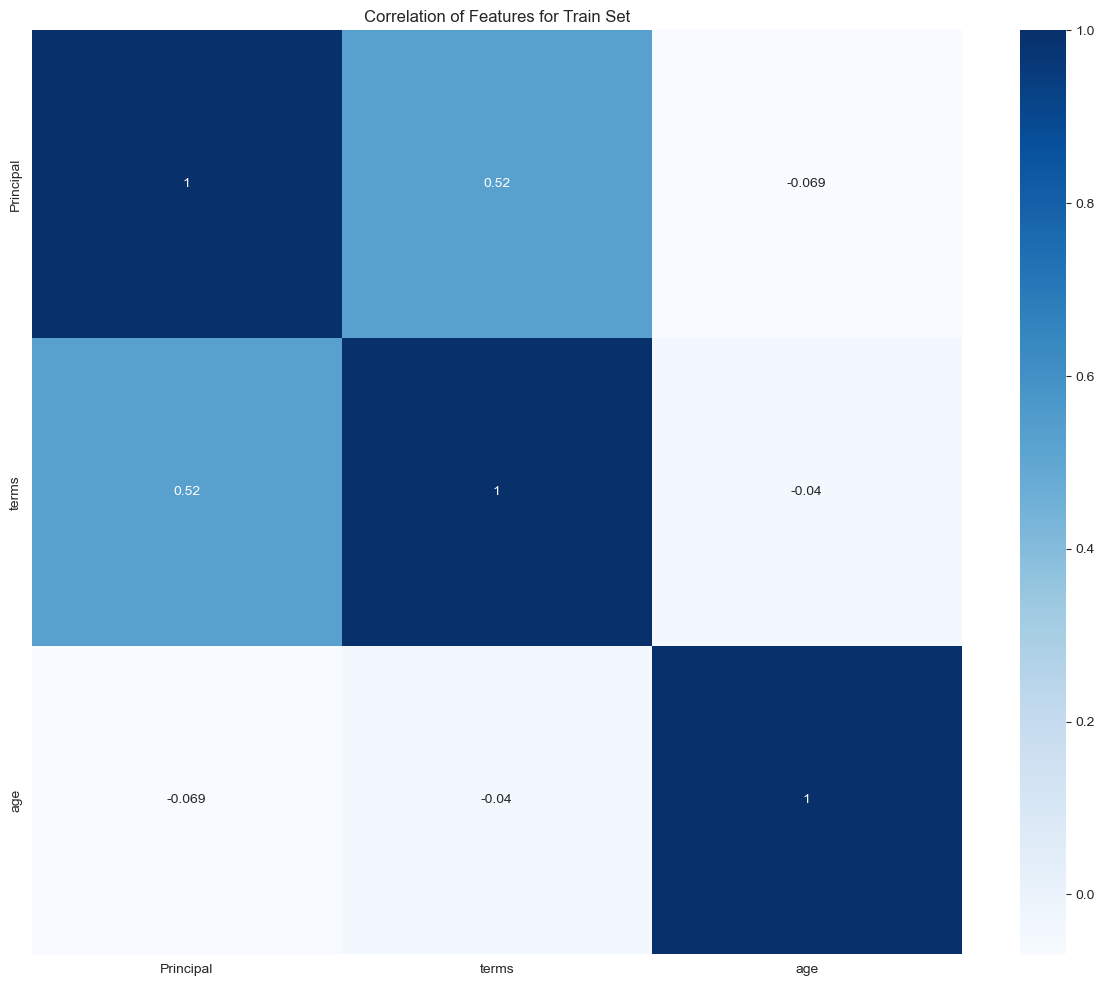

In [11]:
# HeatMap to check the potential or existing correlations before treating the data
plt.figure(figsize=(15, 12))
plt.title("Correlation of Features for Train Set")
sns.heatmap(df.corr(numeric_only=True), vmax=1.0, annot=True, cmap="Blues")
plt.show()

## Let's analyze and visualize the different features depending on whether or not customers repay the loan on time

***This is what we know from a first analysis:*** \
***We know that there more man then women.*** \
***We know from the summary statistics that the minimum principal amount was $300 and the maximum was $1000, and looking at the unique values we know that only 6 different principal amounts were requested.*** \
***We know that the minimum age registered was 19 years old and the maximum age was 51 years old, and looking at the unique values we know that 32 different ages were registered.***

***Let's go a little deeper with this knowledge.***

***Of the 400 people, we can see that 300 paid the loans on time and the remaining 100 went into collection by missing the deadline, the classes are unbalanced.***

In [12]:
df["loan_status"].value_counts()

PAIDOFF       300
COLLECTION    100
Name: loan_status, dtype: int64

***Of the 400 people, we can see that 337 (84.25%) are male and 63 (15.75%) are female.***

In [13]:
df["Gender"].value_counts()

male      337
female     63
Name: Gender, dtype: int64

In [14]:
df["Gender"].value_counts(normalize=True) * 100

male      84.25
female    15.75
Name: Gender, dtype: float64

***Of these 63 women, 84.13% paid on time and the other 15.87% did not pay on time. Of the 337 men, 73.29% paid on time and 26.71% did not pay on time.***

In [15]:
groupby_gender = (
    df.groupby(["Gender"])["loan_status"].value_counts(normalize=True) * 100
)
groupby_gender.unstack(level=-1)

loan_status,COLLECTION,PAIDOFF
Gender,,
female,15.873016,84.126984
male,26.706231,73.293769


***Let us then look at the number of people who, depending on gender and age, pay or do not pay the loans and at what ages do we see that there are more loan requests.***  \
***In this bar chart we can visually confirm that it is more usual for the loan to be in the name of a man, and there is a tendency for people to choose/need higher principal values than lower ones.*** \
***We can observe that there are more people asking for loans from the age of 25, we can associate it with the fact that this is when most people start to have their independence and their life plans come true, but there is no evidences of correlation that proves this fact.***

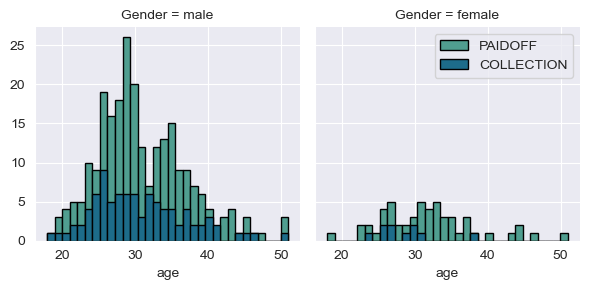

In [16]:
# Plot the bar chart to visualize loan status trow ages split by gender
bins = np.linspace(df.age.min(), df.age.max(), 33)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="crest", col_wrap=2)
g.map(plt.hist, "age", bins=bins, ec="k")

g.axes[1].legend()
plt.show()

***Let us then look at the number of people who, depending on their level of education and age, pay or not pay the loans and at what age there are more requests.***

In [17]:
# group by method, proportions of the education feature
group_by_edu = df.groupby("loan_status")["education"].value_counts(normalize=True) * 100
group_by_edu.unstack(level=-1)

education,Bechalor,High School or Below,Master or Above,college
loan_status,,,,
COLLECTION,11.000000,49.0,1.0,39.000000
PAIDOFF,13.666667,41.0,1.0,44.333333


***With the naked eye we see some differences, but we cannot rely on vision in such similar things, but we evaluated the situation numerically and know the proportions, verifying if it was worth normalizing these data to draw more accurate conclusions with the model.***

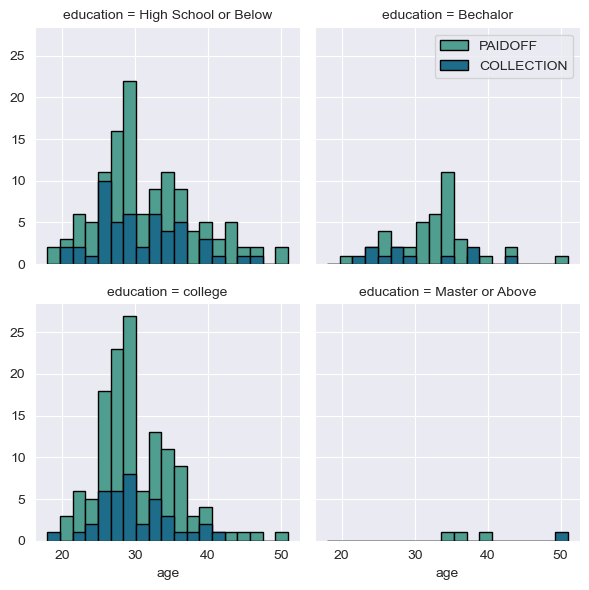

In [18]:
# Plot the bar chart to visualize loan status trow ages split by education
bins = np.linspace(df.age.min(), df.age.max(), 20)
g = sns.FacetGrid(df, col="education", hue="loan_status", palette="crest", col_wrap=2)
g.map(plt.hist, "age", bins=bins, ec="k")

g.axes[1].legend()
plt.show()

***Through these observations below, we have already been able to observe a more concise correlation and that people who usually ask for loans with shorter terms and lower amounts tend to pay it on time.***

***So let's look at the number of people who, depending on the loan they take out and the term of the same, whether or not they repay the loans and what are the loan terms and amounts in which it is verified that there are more people to pay or to enter into collection.***

In [19]:
#
df.groupby(["terms", "Principal"], as_index=False)["loan_status"].value_counts(sort=True)

,terms,Principal,loan_status,count
0,7,300,PAIDOFF,6
1,7,500,PAIDOFF,1
2,7,800,PAIDOFF,1
3,7,900,PAIDOFF,1
4,7,1000,PAIDOFF,11
5,15,500,PAIDOFF,1
6,15,700,PAIDOFF,1
7,15,800,PAIDOFF,63
8,15,800,COLLECTION,22
9,15,900,PAIDOFF,1


In [20]:
# i'm showing the median to see if it differs a lot from the mean showed above
df.pivot_table(values="Principal", index="terms", aggfunc=[np.median])

,median
,Principal
terms,
7,1000
15,800
30,1000


In [21]:
# this pivot table is showing us the mean principal for each terms
df.pivot_table(
    values="Principal", index="loan_status", columns="terms", fill_value=0, margins=True
)

terms,7,15,30,All
loan_status,,,,
COLLECTION,0,892.682927,996.610169,954.00
PAIDOFF,750,893.700787,993.464052,935.00
All,750,893.452381,994.339623,939.75


In [22]:
# i'm showing the median to see if it differs a lot from the mean showed above
df.pivot_table(values="terms", index="Principal", aggfunc=[np.median])

,median
,terms
Principal,
300,7
500,11
700,15
800,15
900,11
1000,30


In [23]:
# this pivot table is showing us the mean terms for each principal
df.pivot_table(
    values="terms", index="loan_status", columns="Principal", fill_value=0, margins=True
)

Principal,300,500,700,800,900,1000,All
loan_status,,,,,,,
COLLECTION,0,0,0,15.652174,0,26.298701,23.850000
PAIDOFF,7,11,15,15.971014,11,24.690909,22.116667
All,7,11,15,15.891304,11,25.107744,22.550000


***In here we can see that for each day in the terms the principals tend to go up 7.79 dollars.***

In [24]:
import statsmodels.formula.api as smf
results = smf.ols('Principal ~ terms', data=df).fit()
results.params

Intercept    764.067764
terms          7.790787
dtype: float64

***In this scatter plot we can visually confirm that there is a tendency that usually people who choose higher terms are getting higher principals too.***

<AxesSubplot: xlabel='terms', ylabel='Principal'>

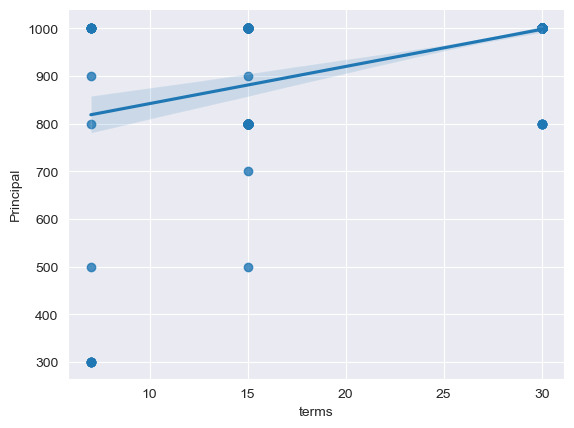

In [25]:
sns.regplot(x='terms', y='Principal', data=df)

***So let's look at the number of people who, depending on the day of the week they make the application and their age, whether or not they repay the loans and which days there are more requests.*** \
***Through this graph we have already managed to get a more concise correlation, we have been able to observe that people who usually borrow at the weekend tend to be late in paying it.***

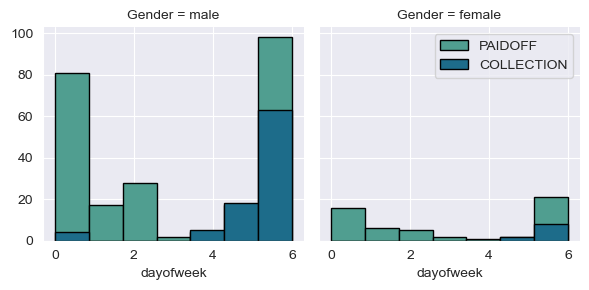

In [26]:
df["dayofweek"] = df["effective_date"].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 8)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="crest", col_wrap=2)
g.map(plt.hist, "dayofweek", bins=bins, ec="k")


g.axes[-1].legend()
plt.show()

In [27]:
df["dayofweek"].value_counts(normalize=True) * 100

6    47.50
0    25.25
5     9.75
2     8.25
1     5.75
4     2.50
3     1.00
Name: dayofweek, dtype: float64

***After the last observation, it is more appropriate to separate the weekend from the weekdays.***

In [28]:
df["weekend"] = df["dayofweek"].apply(lambda x: 1 if (x > 3) else 0)
df.sample(10)

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
188,PAIDOFF,1000,15,2016-09-12,2016-09-26,35,college,male,0,0
57,PAIDOFF,1000,30,2016-09-11,2016-10-10,43,Bechalor,male,6,1
203,PAIDOFF,800,15,2016-09-12,2016-09-26,36,High School or Below,male,0,0
382,PAIDOFF,1000,30,2016-09-13,2016-10-12,28,High School or Below,male,1,0
230,PAIDOFF,1000,30,2016-09-14,2016-10-13,42,High School or Below,male,2,0
284,COLLECTION,1000,30,2016-09-11,2016-10-10,30,High School or Below,female,6,1
104,PAIDOFF,1000,30,2016-09-11,2016-10-10,26,college,male,6,1
236,PAIDOFF,1000,30,2016-09-14,2016-10-13,30,Bechalor,male,2,0
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1
267,COLLECTION,1000,30,2016-09-10,2016-10-09,27,High School or Below,male,5,1


### Conversion of categorical features to numerical ones

***Feature gender, we can put it as a binary value***

In [29]:
df["Gender"].replace(to_replace=["male", "female"], value=[0, 1], inplace=True)
df["Gender"].sample(5)

46     0
159    0
3      1
97     0
264    0
Name: Gender, dtype: int64

## Feature Selection

***Let's now make a new Dataframe with the definitive features that we want to feed our models.*** \
***We use a pandas "dummy" algorithm method to normalize the data in the education feature and then remove the masters category.***

In [30]:
features = df[["Principal", "terms", "age", "Gender", "weekend", "dayofweek"]]
features = pd.concat([features, pd.get_dummies(df["education"])], axis=1)
features.head(5)

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,3,0,1,0,0
1,1000,30,33,1,0,3,1,0,0,0
2,1000,15,27,0,0,3,0,0,0,1
3,1000,30,28,1,1,4,0,0,0,1
4,1000,30,29,0,1,4,0,0,0,1


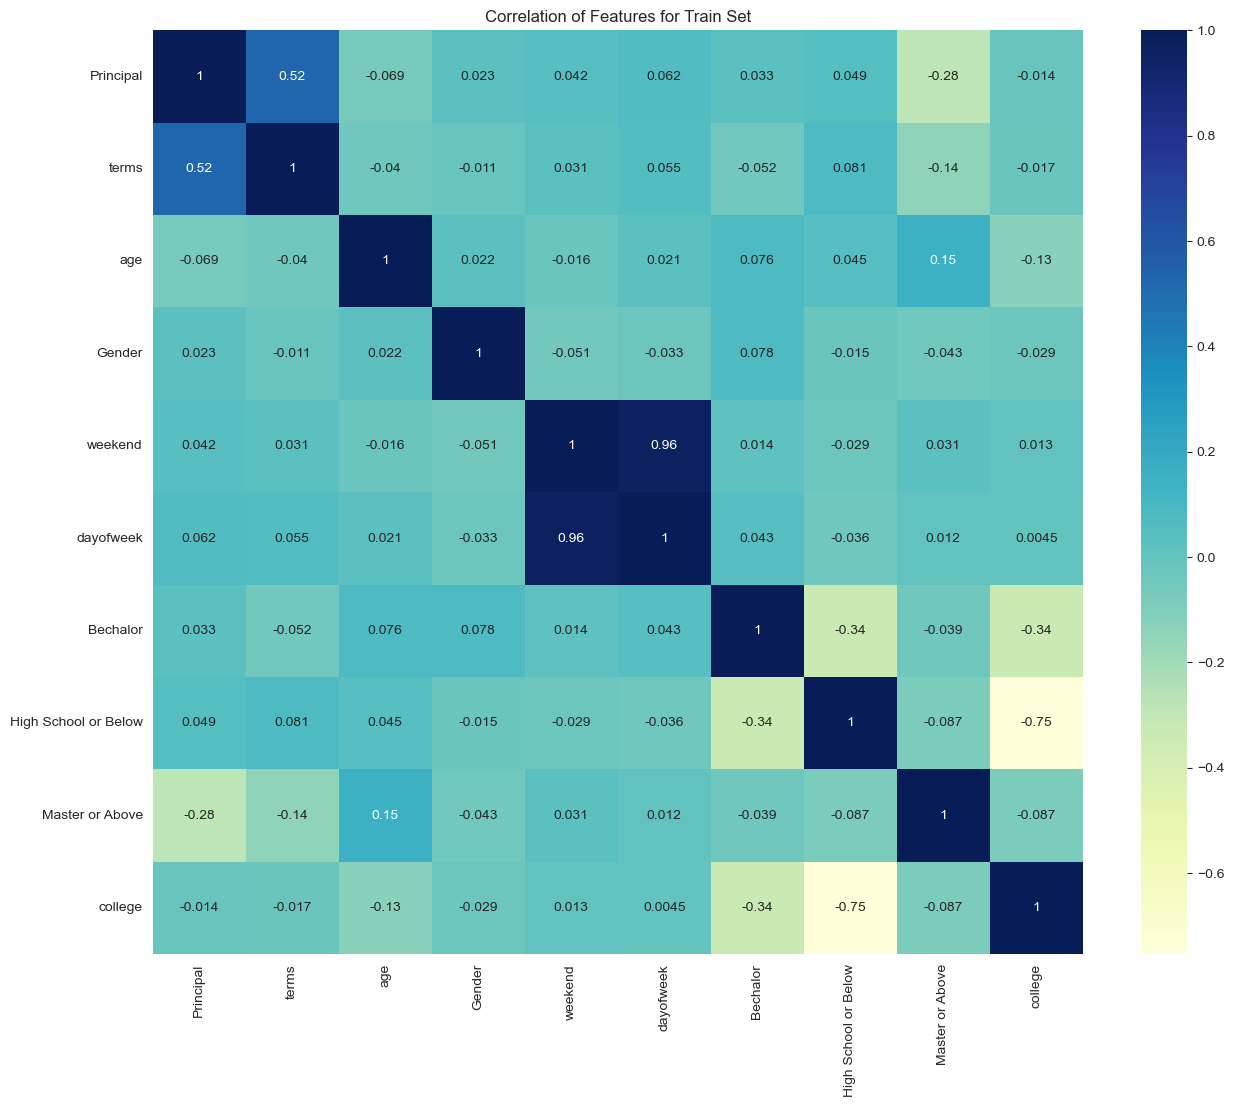

In [31]:
# HeatMap
plt.figure(figsize=(15, 12))
plt.title("Correlation of Features for Train Set")
sns.heatmap(features.corr(numeric_only=True), vmax=1.0, annot=True, cmap="YlGnBu")
plt.show()

In [32]:
X = features
X[0:10]

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,3,0,1,0,0
1,1000,30,33,1,0,3,1,0,0,0
2,1000,15,27,0,0,3,0,0,0,1
3,1000,30,28,1,1,4,0,0,0,1
4,1000,30,29,0,1,4,0,0,0,1
5,1000,30,36,0,1,4,0,0,0,1
6,1000,30,28,0,1,4,0,0,0,1
7,800,15,26,0,1,5,0,0,0,1
8,300,7,29,0,1,5,0,0,0,1
9,1000,15,39,0,1,5,0,1,0,0


In [33]:
y = df['loan_status']
y.shape

(400,)

### Data normalization

In [34]:
from sklearn import preprocessing

# normalize the data
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.50130175,  0.92089421,  2.31334964, -0.43236977, -1.21838912,
        -0.26462433, -0.38655567,  1.15133896, -0.10050378, -0.86855395],
       [ 0.50130175,  0.92089421,  0.32194392,  2.31283513, -1.21838912,
        -0.26462433,  2.5869495 , -0.86855395, -0.10050378, -0.86855395],
       [ 0.50130175, -0.9332552 , -0.67375893, -0.43236977, -1.21838912,
        -0.26462433, -0.38655567, -0.86855395, -0.10050378,  1.15133896],
       [ 0.50130175,  0.92089421, -0.50780846,  2.31283513,  0.82075585,
         0.11888919, -0.38655567, -0.86855395, -0.10050378,  1.15133896],
       [ 0.50130175,  0.92089421, -0.34185798, -0.43236977,  0.82075585,
         0.11888919, -0.38655567, -0.86855395, -0.10050378,  1.15133896]])

# Classification, which method suits best and gets the best accuracy

## Train Test Split

In [35]:
from sklearn.model_selection import train_test_split

# train split test variables
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=4
)
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (300, 10) (300,)
Test set: (100, 10) (100,)


## K-Nearest Neighbors

### Training (To find the best k)

In [36]:
from sklearn.neighbors import KNeighborsClassifier

# test what the best k will be
k = 3
eKNN = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
eKNN

KNeighborsClassifier(n_neighbors=3)

### Prediction (To find the best k)

In [37]:
# evaluate the predictions to see the best k
yhat_knn = eKNN.predict(X_test)
yhat_knn[0:5]

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### Visualization

In [38]:
# foreach k we will fit and predict the score of all k's
Ks = 10
mean_acc = np.zeros((Ks - 1))
std_acc = np.zeros((Ks - 1))
ConfusionMx = []

for k in range(1, Ks):

    kNN_type = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    yhat_knn = kNN_type.predict(X_test)

    mean_acc[k - 1] = np.mean(yhat_knn == y_test)

    std_acc[k - 1] = np.std(yhat_knn == y_test) / np.sqrt(yhat_knn.shape[0])
mean_acc * 100

array([70., 68., 70., 69., 73., 69., 71., 71., 70.])

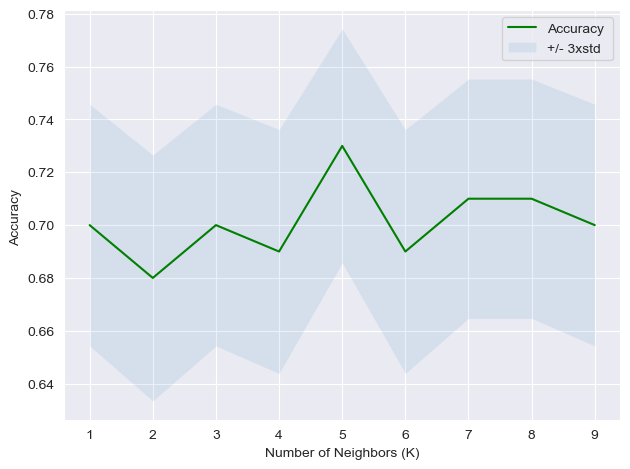

The best accuracy was 73 % with k= 5


In [39]:
plt.plot(range(1, Ks), mean_acc, "g")
plt.fill_between(
    range(1, Ks), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10
)
plt.legend(("Accuracy ", "+/­ 3xstd"))
plt.ylabel("Accuracy ")
plt.xlabel("Number of Neighbors (K)")
plt.tight_layout()
plt.show()
best_k = mean_acc.argmax() + 1
print("The best accuracy was", int(mean_acc.max() * 100), "% with k=", best_k)

### Modeling

In [40]:
k = best_k
eKNN = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
eKNN

KNeighborsClassifier()

### Evaluate KNN Predict

In [41]:
yhat_knn_pred = eKNN.predict(X_test)
yhat_prob_knn = eKNN.predict_proba(X_test)

### KNN Model Accuracy

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.gist_yarg):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[63 13]
 [14 10]]


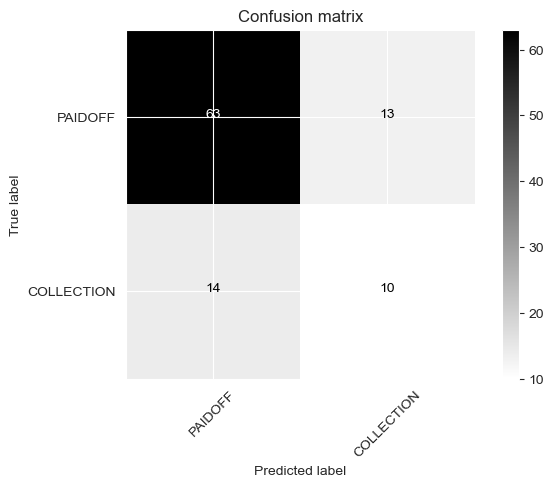

In [43]:
from sklearn.metrics import confusion_matrix
import itertools

cmKNN = confusion_matrix(y_test, yhat_knn_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cmKNN, classes=['PAIDOFF', 'COLLECTION'], normalize= False, title='Confusion matrix')

### HERE (Code is out dated find other way to plot a roc curve)

In [44]:
# from sklearn import metrics
# from sklearn.metrics import plot_roc_curve
# from scikitplot.metrics import plot_roc_curve
# from sklearn.metrics import RocCurveDisplay

metrics.plot_roc_curve(eKNN, X_test, y_test)
plt.show()

NameError: name 'metrics' is not defined

In [45]:
from sklearn.metrics import log_loss, jaccard_score, classification_report

print ("KNN - Logloss é: %.2f" % log_loss(y_test, yhat_prob_knn))
print ("KNN - Jaccard para PAIDOFF é: %.2f" % jaccard_score(y_test, yhat_knn_pred, pos_label='PAIDOFF'))
print ("KNN - Jaccard para COLLECTION é: %.2f" % jaccard_score(y_test, yhat_knn_pred, pos_label='COLLECTION'))
print (classification_report(y_test, yhat_knn_pred))

KNN - Logloss é: 1.17
KNN - Jaccard para PAIDOFF é: 0.70
KNN - Jaccard para COLLECTION é: 0.27
              precision    recall  f1-score   support

  COLLECTION       0.43      0.42      0.43        24
     PAIDOFF       0.82      0.83      0.82        76

    accuracy                           0.73       100
   macro avg       0.63      0.62      0.62       100
weighted avg       0.73      0.73      0.73       100



## Decision Tree

### Modeling

In [46]:
from sklearn.tree import DecisionTreeClassifier

eTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
eTree

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [47]:
eTree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

### Visualization

In [48]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

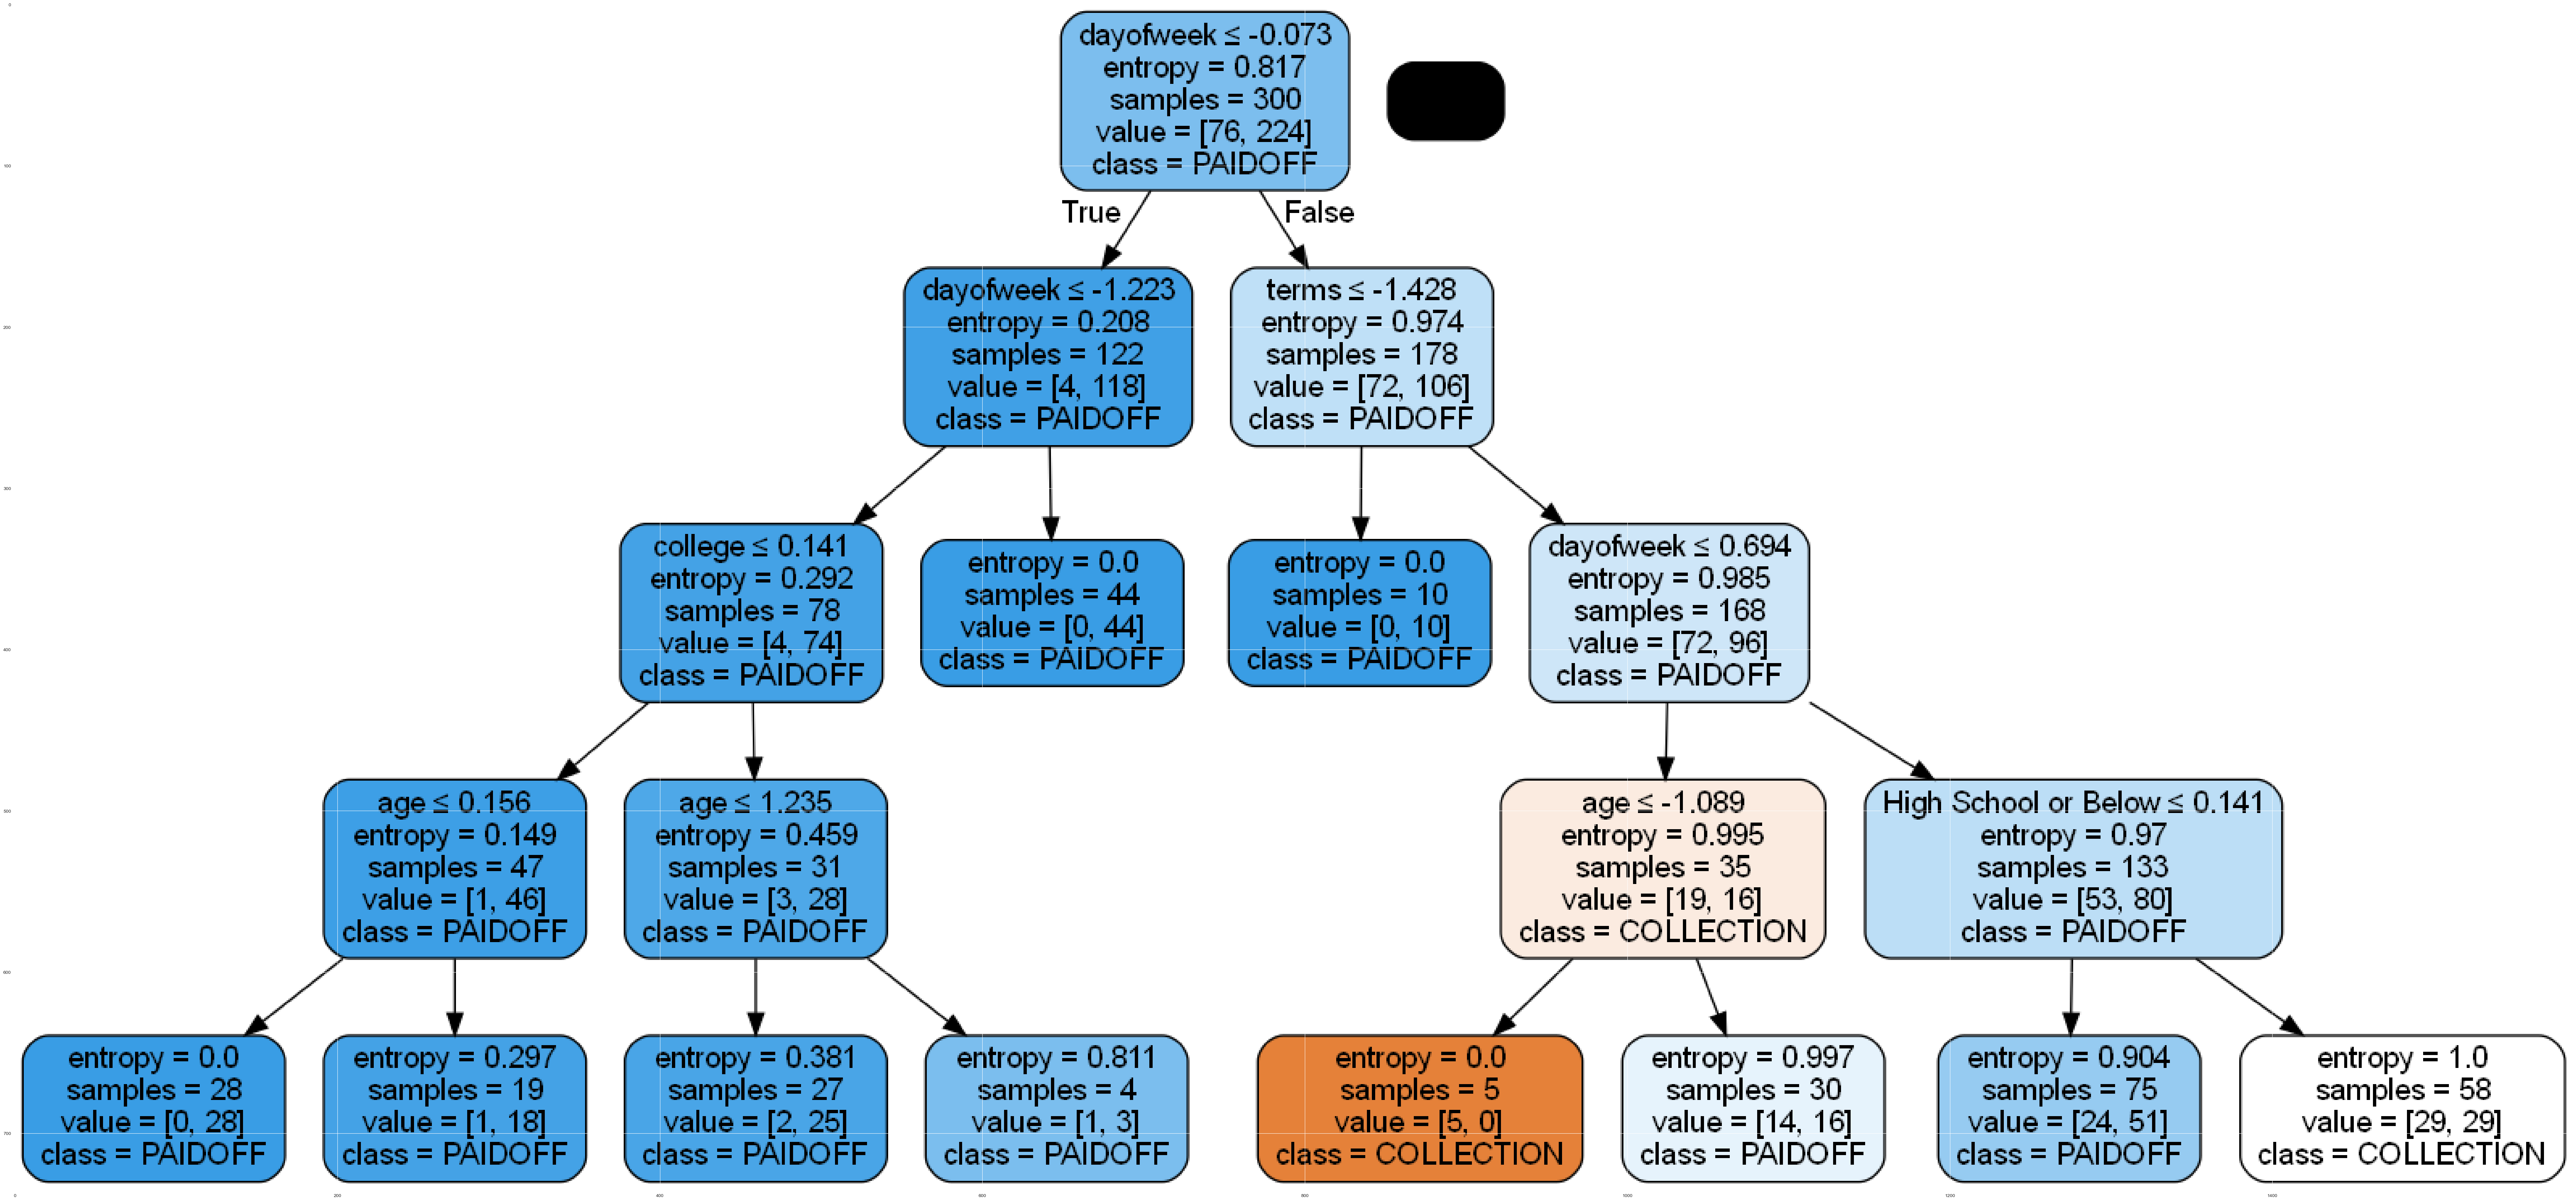

In [49]:
dot_data = StringIO()
filename = "eTree(v0).png"
featureNames = features.columns[:]
out = tree.export_graphviz(
    eTree,
    feature_names=featureNames,
    out_file=dot_data,
    class_names=np.unique(y_train),
    filled=True,
    proportion=False,
    rotate=False,
    rounded=True,
    special_characters=True,
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img, interpolation="nearest")

### Evaluate DT Predict

In [50]:
yhat_dt_pred = eTree.predict(X_test)
yhat_prob_dt = eTree.predict_proba(X_test)

### DT Model Accuracy

Confusion matrix, without normalization
[[64 12]
 [16  8]]


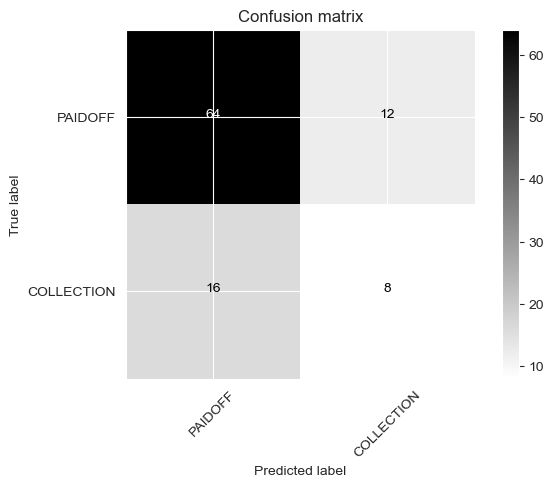

In [51]:
cmDT = confusion_matrix(y_test, yhat_dt_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cmDT, classes=['PAIDOFF','COLLECTION'], normalize= False, title='Confusion matrix')

In [52]:
metrics.plot_roc_curve(eTree, X_test, y_test)
plt.show()

NameError: name 'metrics' is not defined

In [53]:
print ("DT - Logloss é: %.2f" % log_loss(y_test, yhat_prob_dt))
print ("DT - Jaccard para PAIDOFF é: %.2f" % jaccard_score(y_test, yhat_dt_pred, pos_label='PAIDOFF'))
print ("DT - Jaccard para COLLECTION é: %.2f" % jaccard_score(y_test, yhat_dt_pred, pos_label='COLLECTION'))
print (classification_report(y_test, yhat_dt_pred))

DT - Logloss é: 0.41
DT - Jaccard para PAIDOFF é: 0.70
DT - Jaccard para COLLECTION é: 0.22
              precision    recall  f1-score   support

  COLLECTION       0.40      0.33      0.36        24
     PAIDOFF       0.80      0.84      0.82        76

    accuracy                           0.72       100
   macro avg       0.60      0.59      0.59       100
weighted avg       0.70      0.72      0.71       100



## SVM

### Modeling

In [54]:
import scipy.optimize as opt
from sklearn import svm

eSVMrbf = svm.SVC(kernel='rbf')
eSVMrbf.fit(X_train, y_train)

SVC()

In [55]:
eSVMpoly = svm.SVC(kernel='poly')
eSVMpoly.fit(X_train, y_train)

SVC(kernel='poly')

In [56]:
eSVMsig = svm.SVC(kernel='sigmoid')
eSVMsig.fit(X_train, y_train)

SVC(kernel='sigmoid')

### Evaluate SVM Predict

In [57]:
yhat_SVMrbf_pred = eSVMrbf.predict(X_test)
yhat_SVMpoly_pred = eSVMpoly.predict(X_test)
yhat_SVMsig_pred = eSVMsig.predict(X_test)

### SVM Model Accuracy 

Confusion matrix, without normalization
[[74  2]
 [22  2]]
Confusion matrix, without normalization
[[74  2]
 [22  2]]
Confusion matrix, without normalization
[[72  4]
 [24  0]]


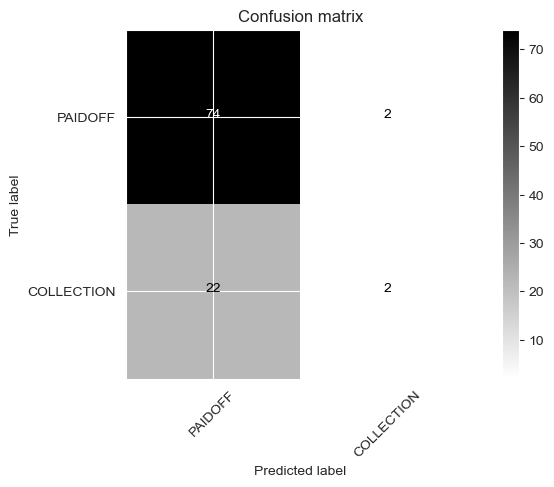

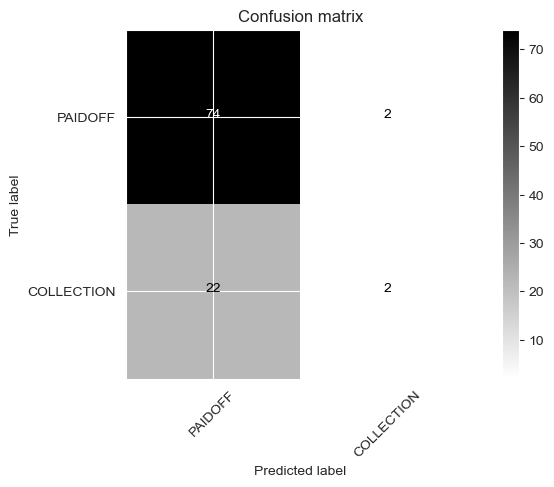

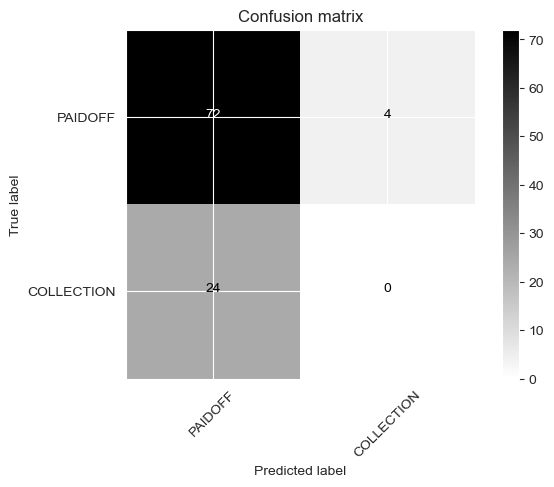

In [58]:
cmSVMrbf = confusion_matrix(y_test, yhat_SVMrbf_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cmSVMrbf, classes=['PAIDOFF','COLLECTION'], normalize= False, title='Confusion matrix')

#############################################################################################################

cmSVMrbf = confusion_matrix(y_test, yhat_SVMpoly_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cmSVMrbf, classes=['PAIDOFF','COLLECTION'], normalize= False, title='Confusion matrix')

#############################################################################################################

cmSVMrbf = confusion_matrix(y_test, yhat_SVMsig_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cmSVMrbf, classes=['PAIDOFF','COLLECTION'], normalize= False, title='Confusion matrix')


In [59]:
metrics.plot_roc_curve(eSVMrbf, X_test, y_test)
metrics.plot_roc_curve(eSVMpoly, X_test, y_test)
metrics.plot_roc_curve(eSVMsig, X_test, y_test)
plt.show()

NameError: name 'metrics' is not defined

In [60]:
# SVM Radical Basis Function
print ("SVM Radical Basis Function - Jaccard para PAIDOFF é: %.2f" % jaccard_score(y_test, yhat_SVMrbf_pred, pos_label='PAIDOFF'))
print ("SVM Radical Basis Function - Jaccard para COLLECTION é: %.2f" % jaccard_score(y_test, yhat_SVMrbf_pred, pos_label='COLLECTION'))
print (classification_report(y_test, yhat_SVMrbf_pred))
print()

# SVM Polynomial
print ("SVM Polynomial - Jaccard para PAIDOFF é: %.2f" % jaccard_score(y_test, yhat_SVMpoly_pred, pos_label='PAIDOFF'))
print ("SVM Polynomial - Jaccard para COLLECTION é: %.2f" % jaccard_score(y_test, yhat_SVMpoly_pred, pos_label='COLLECTION'))
print (classification_report(y_test, yhat_SVMpoly_pred))
print()

# SVM Sigmoid
print ("SVM Sigmoid - Jaccard para PAIDOFF é: %.2f" % jaccard_score(y_test, yhat_SVMsig_pred, pos_label='PAIDOFF'))
print ("SVM Sigmoid - Jaccard para COLLECTION é: %.2f" % jaccard_score(y_test, yhat_SVMsig_pred, pos_label='COLLECTION'))
print (classification_report(y_test, yhat_SVMsig_pred))

SVM Radical Basis Function - Jaccard para PAIDOFF é: 0.76
SVM Radical Basis Function - Jaccard para COLLECTION é: 0.08
              precision    recall  f1-score   support

  COLLECTION       0.50      0.08      0.14        24
     PAIDOFF       0.77      0.97      0.86        76

    accuracy                           0.76       100
   macro avg       0.64      0.53      0.50       100
weighted avg       0.71      0.76      0.69       100


SVM Polynomial - Jaccard para PAIDOFF é: 0.76
SVM Polynomial - Jaccard para COLLECTION é: 0.08
              precision    recall  f1-score   support

  COLLECTION       0.50      0.08      0.14        24
     PAIDOFF       0.77      0.97      0.86        76

    accuracy                           0.76       100
   macro avg       0.64      0.53      0.50       100
weighted avg       0.71      0.76      0.69       100


SVM Sigmoid - Jaccard para PAIDOFF é: 0.72
SVM Sigmoid - Jaccard para COLLECTION é: 0.00
              precision    recall  f1-sco

## Logistic Regression

### Modeling

In [61]:
from sklearn.linear_model import LogisticRegression
eLr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)
eLr

LogisticRegression(C=0.01, solver='liblinear')

### Evaluate LR Predict

In [62]:
yhat_lr_pred = eLr.predict(X_test)
yhat_prob_lr = eLr.predict_proba(X_test)


### LR Model Accuracy

Confusion matrix, without normalization
[[67  9]
 [14 10]]


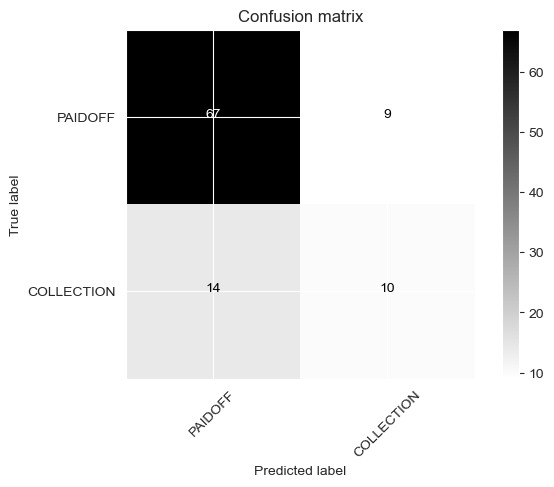

In [63]:
cmLR = confusion_matrix(y_test, yhat_lr_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cmLR, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [64]:
metrics.plot_roc_curve(eLr, X_test, y_test)
plt.show()

NameError: name 'metrics' is not defined

In [65]:
print ("LR - Logloss é: %.2f" % log_loss(y_test, yhat_prob_lr))
print ("LR - Jaccard para PAIDOFF é: %.2f" % jaccard_score(y_test, yhat_lr_pred, pos_label='PAIDOFF'))
print ("LR - Jaccard para COLLECTION é: %.2f" % jaccard_score(y_test, yhat_lr_pred, pos_label='COLLECTION'))
print (classification_report(y_test, yhat_lr_pred))

LR - Logloss é: 0.54
LR - Jaccard para PAIDOFF é: 0.74
LR - Jaccard para COLLECTION é: 0.30
              precision    recall  f1-score   support

  COLLECTION       0.53      0.42      0.47        24
     PAIDOFF       0.83      0.88      0.85        76

    accuracy                           0.77       100
   macro avg       0.68      0.65      0.66       100
weighted avg       0.75      0.77      0.76       100

